In [1]:
! pip install glove_python_binary

In [2]:
import gensim
from gensim.models import Word2Vec, FastText
from glove import Corpus, Glove
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data_dir = '/content/drive/MyDrive/'

from google.colab import drive
drive.mount('/content/drive')

spam = pd.read_csv(data_dir + 'spam.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# spam word
spam_text = spam[spam['v1'] == 'spam']
spam_word = []
for text in spam_text['v2']:
    spam_word += word_tokenize(text)
spam_word = pd.DataFrame(spam_word)
spam_word.to_csv('sapm_class.csv')

# ham word    
ham_text = spam[spam['v1'] == 'ham']
ham_word = []
for text in ham_text['v2']:
    ham_word += word_tokenize(text)
ham_word = pd.DataFrame(ham_word)
ham_word.to_csv('ham_class.csv')

Skip-gram

In [5]:
corpus = gensim.models.word2vec.Text8Corpus(data_dir + 'spam.csv')
word2vec = Word2Vec(corpus,min_count=5,vector_size=100,window=3, epochs=300, sg=1)
word2vec.save('w2v_model')

w2v_model = Word2Vec.load('w2v_model')

In [6]:
w2v_model.wv.most_similar('think',topn=10)

[('alright', 0.40617871284484863),
 ('mind.', 0.40051937103271484),
 ('you,', 0.39486655592918396),
 ('know', 0.3927915692329407),
 ('could', 0.391510933637619),
 ('hope', 0.3779635429382324),
 ('up,', 0.369353324174881),
 ('there!', 0.36861956119537354),
 ('turns', 0.3638991415500641),
 ('respond', 0.36347976326942444)]

In [7]:
w2v_model.wv.most_similar(positive=['dad', 'she'], negative= ['he'], topn=10)

[('marry', 0.4031282663345337),
 ('not.', 0.379160076379776),
 ('using', 0.3658783733844757),
 ('playing', 0.3604566156864166),
 ('82277.', 0.3561125695705414),
 ('picking', 0.3560771048069),
 ('ham,O', 0.3554641604423523),
 ('Like', 0.3502753674983978),
 ('ham,ÌÏ', 0.3474866449832916),
 ('plenty', 0.33650729060173035)]

FastText

In [8]:
fastText = FastText(vector_size=100,window=2)
fastText.build_vocab(corpus_file=data_dir + 'spam.csv')

fastText.train(
    corpus_file=data_dir+'spam.csv',
    epochs=500,
    total_examples=fastText.corpus_count,
    total_words=fastText.corpus_total_words
)
fastText.save('ft_model')
ft_model = FastText.load('ft_model')

In [9]:
ft_model.wv.similarity('good', 'fine')

0.2538486

In [10]:
ft_model.wv.most_similar('good', topn=10)

[('great', 0.5915005803108215),
 ('good,', 0.5831867456436157),
 ('good.', 0.5435401201248169),
 ('nice', 0.49988114833831787),
 ('ham,Good', 0.46267014741897583),
 ('great.', 0.4266519248485565),
 ('food', 0.41923272609710693),
 ('Good', 0.40277522802352905),
 ('lovely', 0.3698684275150299),
 ('last', 0.36935585737228394)]

Glove

In [39]:
data = gensim.models.word2vec.Text8Corpus(data_dir+'spam.csv')
corpus = Corpus()

corpus.fit(data,window=2)

glove = Glove(no_components=5, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=200, no_threads=4, verbose=False)

glove.add_dictionary(corpus.dictionary)
glove.save('gv_model')
gv_model = Glove.load('gv_model')

In [13]:
gv_model.most_similar('very')

[('ham,Right', 0.988582634330457),
 ('150p/Mtmsgrcvd18+"', 0.986789515243159),
 ('charge', 0.9845830101142906),
 ('tired', 0.9845648853108989)]

Visualization

In [14]:
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib as mpl

In [15]:
FILTERS = "([~,!?\"':.;|~)^(])"
CHANGE_FILTER = re.compile(FILTERS)

EXP = "[1234567890\-]"
CHANGE_EXP = re.compile(EXP)

words = []
for line in spam['v2']:
    line = CHANGE_FILTER.sub("", line)
    line = CHANGE_EXP.sub("", line)
    token = word_tokenize(line)
    words+=token

freq_list = Counter(words).most_common(800)
vocab = [i[0] for i in freq_list if len(i[0])>1]

word2vector

In [34]:
w2v_tokens = []
for word in w2v_model.wv.key_to_index:
  w2v_tokens.append(w2v_model.wv[word])

fastText

In [37]:
ft_tokens = []
for word in ft_model.wv.key_to_index:
  ft_tokens.append(ft_model.wv[word])

In [35]:
def tsne_2d(title, tsne,tokens):
    X_tsne = tsne.fit_transform(tokens[:300])
    df = pd.DataFrame(X_tsne, index=vocab[:300], columns=['x', 'y'])
    
    %matplotlib inline
    fig = plt.figure()
    fig.set_size_inches(20, 10)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df["x"], df["y"])
    for word, pos in list(df.iterrows()):
        ax.annotate(word, pos, fontsize=12)
    plt.title(title)
    plt.show()

tsne = TSNE(perplexity=30,n_components=2, init='pca', n_iter=3500, random_state=12)

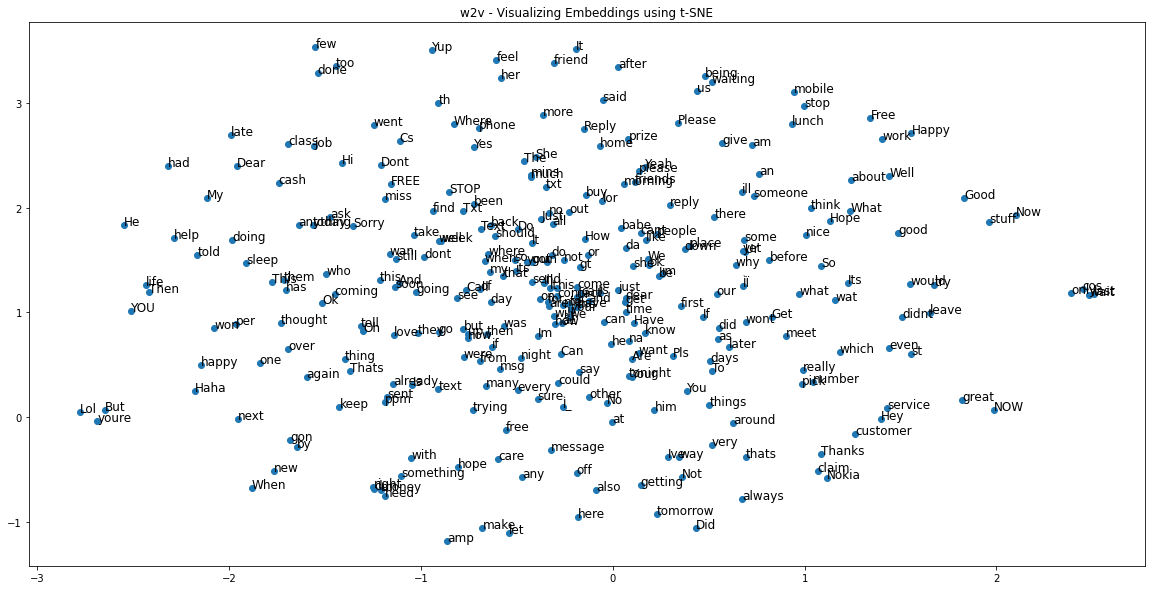

In [36]:
tsne_2d('w2v - Visualizing Embeddings using t-SNE', tsne, w2v_tokens)

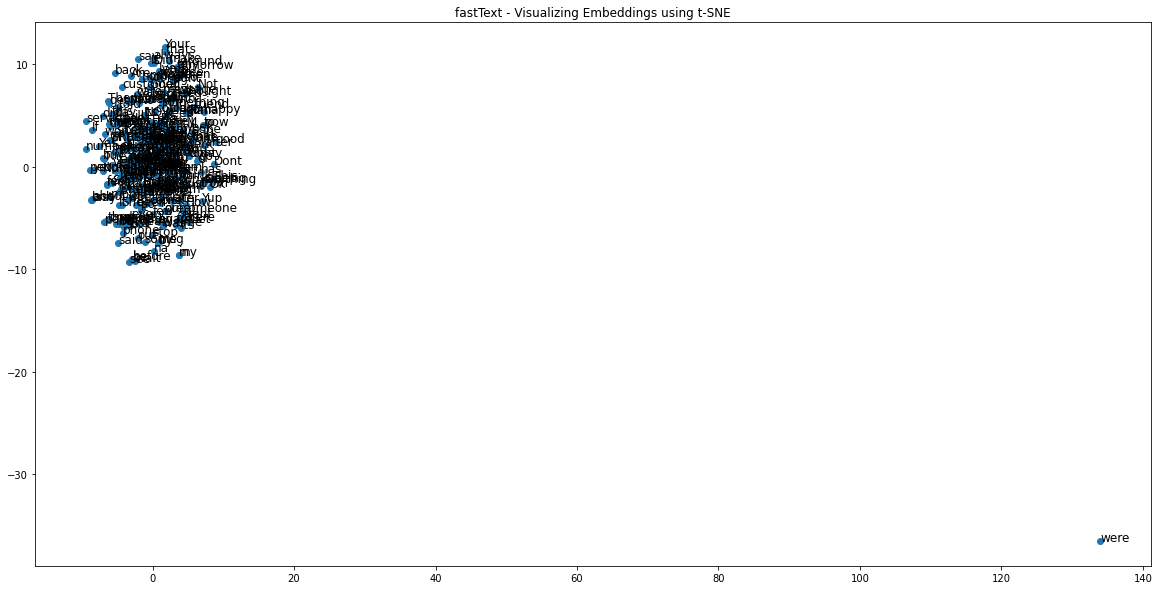

In [38]:
tsne_2d('fastText - Visualizing Embeddings using t-SNE', tsne, ft_tokens)

In [27]:
def w2v_sg(path):
  corpus = gensim.models.word2vec.Text8Corpus(path)
  word2vec = Word2Vec(corpus,min_count=5,vector_size=100,window=3, epochs=300, sg=1)
  word2vec.save(f'{path}_w2v_model')
  return word2vec

def fasttext(path):
  fastText = FastText(vector_size=100,window=2)
  fastText.build_vocab(corpus_file=path)

  fastText.train(
      corpus_file=path,
      epochs=500,
      total_examples=fastText.corpus_count,
      total_words=fastText.corpus_total_words
  )
  fastText.save(f'{path}_ft_model')
  return fastText

def glove(path):
  data = gensim.models.word2vec.Text8Corpus(path)
  corpus = Corpus()

  corpus.fit(data,window=2)

  glove = Glove(no_components=5, learning_rate=0.05)
  glove.fit(corpus.matrix, epochs=200, no_threads=4, verbose=False)

  glove.add_dictionary(corpus.dictionary)
  glove.save(f'{path}_gv_model')
  return glove

